In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rewards = tf.placeholder(tf.float32, [None], name='rewards')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rewards, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [6]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rewards, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    #glossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    ###################################################
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                   labels=rates)) # 0-1
    dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    #dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    ######################################################
    actions_pred = tf.argmax(input=actions_logits, axis=1, output_type=actions.dtype)
    mask_equal = tf.equal(x=actions_pred, y=actions)
    gQs_equal = tf.boolean_mask(mask=mask_equal, tensor=gQs)
    #if len(gQs_equal) > 0:
    if gQs_equal.shape[0] > 0:
        rates_equal = tf.boolean_mask(mask=mask_equal, tensor=rates)
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                        labels=rates_equal)) # 0-1
        targetQs_equal = tf.boolean_mask(mask=mask_equal, tensor=targetQs)
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_equal, # GAN
                                                                        labels=tf.nn.sigmoid(targetQs_equal))) # 0-1
        #dlossQ += tf.reduce_mean(tf.square(gQs_equal - targetQs_equal)) # DQN
    ########################################################
    mask_notequal = tf.not_equal(x=actions_pred, y=actions)
    gQs_notequal = tf.boolean_mask(mask=mask_notequal, tensor=gQs)
    #if len(gQs_notequal) > 0:
    if gQs_notequal.shape[0] > 0:
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                        labels=tf.zeros_like(gQs_notequal))) # 0-1
        rewards_notequal = tf.boolean_mask(mask=mask_notequal, tensor=rewards)
        dloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs_notequal, # GAN
                                                                        labels=tf.nn.sigmoid(rewards_notequal))) # 0-1
        #dlossQ += tf.reduce_mean(tf.square(gQs_notequal - rewards_notequal)) # DQN
    return actions_logits, gQs, gloss, dloss

In [7]:
def model_opt(g_loss, d_loss, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(d_learning_rate).minimize(d_loss, var_list=d_vars)
    return g_opt, d_opt

In [8]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rewards, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs, 
            rewards=self.rewards, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss,
                                           g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

In [9]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [10]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [11]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [12]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [13]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [14]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list = [], []
gloss_list, dloss_list = [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dloss_batch = [], []
        state = env.reset() # each episode
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx_arr = np.arange(memory_size// batch_size)
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dloss, _ = sess.run([model.d_loss, model.d_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.rewards: rewards,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], feed_dict = {model.states: states, 
                                                                          model.actions: actions,
                                                                          model.rewards: rewards,
                                                                          model.targetQs: targetQs, 
                                                                          model.rates: rates})
            gloss_batch.append(gloss)
            dloss_batch.append(dloss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dloss:{:.4f}'.format(np.mean(dloss_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        gloss_list.append([ep, np.mean(gloss_batch)])
        dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:18.0000 R:18.0000 rate:0.0360 gloss:1.3555 dloss:1.3891 exploreP:0.9982
Episode:1 meanR:19.5000 R:21.0000 rate:0.0420 gloss:1.3582 dloss:1.3889 exploreP:0.9961
Episode:2 meanR:17.6667 R:14.0000 rate:0.0280 gloss:1.3552 dloss:1.3773 exploreP:0.9948
Episode:3 meanR:18.7500 R:22.0000 rate:0.0440 gloss:1.3605 dloss:1.3818 exploreP:0.9926
Episode:4 meanR:19.8000 R:24.0000 rate:0.0480 gloss:1.3580 dloss:1.3748 exploreP:0.9902
Episode:5 meanR:20.1667 R:22.0000 rate:0.0440 gloss:1.3627 dloss:1.3800 exploreP:0.9881
Episode:6 meanR:20.0000 R:19.0000 rate:0.0380 gloss:1.3598 dloss:1.3697 exploreP:0.9862
Episode:7 meanR:19.7500 R:18.0000 rate:0.0360 gloss:1.3533 dloss:1.3700 exploreP:0.9845
Episode:8 meanR:22.5556 R:45.0000 rate:0.0900 gloss:1.3601 dloss:1.3679 exploreP:0.9801
Episode:9 meanR:23.2000 R:29.0000 rate:0.0580 gloss:1.3618 dloss:1.3664 exploreP:0.9773
Episode:10 meanR:23.2727 R:24.0000 rate:0.0480 gloss:1.3620 dloss:1.3668 exploreP:0.9750
Episode:11 meanR:23.3333 R:24.0

Episode:93 meanR:20.9787 R:23.0000 rate:0.0460 gloss:1.3245 dloss:1.3241 exploreP:0.8228
Episode:94 meanR:20.8737 R:11.0000 rate:0.0220 gloss:1.3151 dloss:1.3150 exploreP:0.8219
Episode:95 meanR:20.7708 R:11.0000 rate:0.0220 gloss:1.3169 dloss:1.3169 exploreP:0.8210
Episode:96 meanR:20.6701 R:11.0000 rate:0.0220 gloss:1.3246 dloss:1.3248 exploreP:0.8201
Episode:97 meanR:20.6429 R:18.0000 rate:0.0360 gloss:1.3218 dloss:1.3220 exploreP:0.8187
Episode:98 meanR:20.8283 R:39.0000 rate:0.0780 gloss:1.3192 dloss:1.3191 exploreP:0.8155
Episode:99 meanR:20.9000 R:28.0000 rate:0.0560 gloss:1.3153 dloss:1.3155 exploreP:0.8133
Episode:100 meanR:20.8400 R:12.0000 rate:0.0240 gloss:1.3136 dloss:1.3138 exploreP:0.8123
Episode:101 meanR:21.0100 R:38.0000 rate:0.0760 gloss:1.3203 dloss:1.3200 exploreP:0.8093
Episode:102 meanR:21.0000 R:13.0000 rate:0.0260 gloss:1.3105 dloss:1.3106 exploreP:0.8082
Episode:103 meanR:20.9000 R:12.0000 rate:0.0240 gloss:1.3205 dloss:1.3209 exploreP:0.8073
Episode:104 meanR

Episode:185 meanR:19.2700 R:20.0000 rate:0.0400 gloss:1.3239 dloss:1.3238 exploreP:0.6886
Episode:186 meanR:19.4400 R:32.0000 rate:0.0640 gloss:1.3237 dloss:1.3237 exploreP:0.6865
Episode:187 meanR:19.4500 R:12.0000 rate:0.0240 gloss:1.3139 dloss:1.3136 exploreP:0.6857
Episode:188 meanR:19.4200 R:9.0000 rate:0.0180 gloss:1.3442 dloss:1.3452 exploreP:0.6851
Episode:189 meanR:19.4300 R:12.0000 rate:0.0240 gloss:1.3206 dloss:1.3207 exploreP:0.6843
Episode:190 meanR:19.3500 R:16.0000 rate:0.0320 gloss:1.3231 dloss:1.3230 exploreP:0.6832
Episode:191 meanR:19.3300 R:9.0000 rate:0.0180 gloss:1.3162 dloss:1.3162 exploreP:0.6826
Episode:192 meanR:19.4000 R:23.0000 rate:0.0460 gloss:1.3199 dloss:1.3199 exploreP:0.6810
Episode:193 meanR:19.3600 R:19.0000 rate:0.0380 gloss:1.3232 dloss:1.3233 exploreP:0.6798
Episode:194 meanR:19.3600 R:11.0000 rate:0.0220 gloss:1.3267 dloss:1.3266 exploreP:0.6790
Episode:195 meanR:19.3900 R:14.0000 rate:0.0280 gloss:1.3300 dloss:1.3304 exploreP:0.6781
Episode:196 

Episode:277 meanR:15.7900 R:15.0000 rate:0.0300 gloss:1.3099 dloss:1.3101 exploreP:0.5979
Episode:278 meanR:15.9000 R:27.0000 rate:0.0540 gloss:1.3172 dloss:1.3171 exploreP:0.5963
Episode:279 meanR:15.9000 R:10.0000 rate:0.0200 gloss:1.3166 dloss:1.3168 exploreP:0.5958
Episode:280 meanR:15.9600 R:17.0000 rate:0.0340 gloss:1.3187 dloss:1.3187 exploreP:0.5948
Episode:281 meanR:15.6600 R:15.0000 rate:0.0300 gloss:1.3215 dloss:1.3213 exploreP:0.5939
Episode:282 meanR:15.5800 R:10.0000 rate:0.0200 gloss:1.3197 dloss:1.3200 exploreP:0.5933
Episode:283 meanR:15.5600 R:11.0000 rate:0.0220 gloss:1.3179 dloss:1.3180 exploreP:0.5927
Episode:284 meanR:15.6500 R:20.0000 rate:0.0400 gloss:1.3112 dloss:1.3112 exploreP:0.5915
Episode:285 meanR:15.6200 R:17.0000 rate:0.0340 gloss:1.3139 dloss:1.3141 exploreP:0.5905
Episode:286 meanR:15.4200 R:12.0000 rate:0.0240 gloss:1.3257 dloss:1.3260 exploreP:0.5898
Episode:287 meanR:15.4400 R:14.0000 rate:0.0280 gloss:1.3176 dloss:1.3175 exploreP:0.5890
Episode:28

Episode:369 meanR:15.3500 R:18.0000 rate:0.0360 gloss:1.3128 dloss:1.3128 exploreP:0.5223
Episode:370 meanR:15.2300 R:9.0000 rate:0.0180 gloss:1.3155 dloss:1.3153 exploreP:0.5218
Episode:371 meanR:15.1100 R:10.0000 rate:0.0200 gloss:1.3108 dloss:1.3108 exploreP:0.5213
Episode:372 meanR:14.8500 R:10.0000 rate:0.0200 gloss:1.3179 dloss:1.3178 exploreP:0.5208
Episode:373 meanR:14.8900 R:16.0000 rate:0.0320 gloss:1.3124 dloss:1.3123 exploreP:0.5200
Episode:374 meanR:14.9700 R:24.0000 rate:0.0480 gloss:1.3133 dloss:1.3135 exploreP:0.5188
Episode:375 meanR:14.9300 R:9.0000 rate:0.0180 gloss:1.3162 dloss:1.3162 exploreP:0.5183
Episode:376 meanR:14.7900 R:9.0000 rate:0.0180 gloss:1.3177 dloss:1.3175 exploreP:0.5179
Episode:377 meanR:14.7500 R:11.0000 rate:0.0220 gloss:1.3174 dloss:1.3173 exploreP:0.5173
Episode:378 meanR:14.5700 R:9.0000 rate:0.0180 gloss:1.3212 dloss:1.3211 exploreP:0.5168
Episode:379 meanR:14.6500 R:18.0000 rate:0.0360 gloss:1.3128 dloss:1.3128 exploreP:0.5159
Episode:380 me

Episode:461 meanR:13.2500 R:14.0000 rate:0.0280 gloss:1.3230 dloss:1.3231 exploreP:0.4641
Episode:462 meanR:13.3800 R:23.0000 rate:0.0460 gloss:1.3210 dloss:1.3211 exploreP:0.4631
Episode:463 meanR:13.1700 R:16.0000 rate:0.0320 gloss:1.3182 dloss:1.3182 exploreP:0.4623
Episode:464 meanR:13.1900 R:11.0000 rate:0.0220 gloss:1.3329 dloss:1.3338 exploreP:0.4618
Episode:465 meanR:13.1900 R:9.0000 rate:0.0180 gloss:1.3106 dloss:1.3107 exploreP:0.4614
Episode:466 meanR:13.1700 R:10.0000 rate:0.0200 gloss:1.3211 dloss:1.3209 exploreP:0.4610
Episode:467 meanR:13.1900 R:16.0000 rate:0.0320 gloss:1.3185 dloss:1.3185 exploreP:0.4603
Episode:468 meanR:13.2600 R:17.0000 rate:0.0340 gloss:1.3176 dloss:1.3176 exploreP:0.4595
Episode:469 meanR:13.2100 R:13.0000 rate:0.0260 gloss:1.3164 dloss:1.3165 exploreP:0.4589
Episode:470 meanR:13.2700 R:15.0000 rate:0.0300 gloss:1.3170 dloss:1.3169 exploreP:0.4582
Episode:471 meanR:13.2900 R:12.0000 rate:0.0240 gloss:1.3157 dloss:1.3156 exploreP:0.4577
Episode:472

Episode:553 meanR:13.4300 R:10.0000 rate:0.0200 gloss:1.3256 dloss:1.3257 exploreP:0.4118
Episode:554 meanR:13.4100 R:10.0000 rate:0.0200 gloss:1.3191 dloss:1.3193 exploreP:0.4114
Episode:555 meanR:13.3900 R:14.0000 rate:0.0280 gloss:1.3137 dloss:1.3138 exploreP:0.4108
Episode:556 meanR:13.3600 R:13.0000 rate:0.0260 gloss:1.3282 dloss:1.3280 exploreP:0.4103
Episode:557 meanR:13.2800 R:16.0000 rate:0.0320 gloss:1.3209 dloss:1.3206 exploreP:0.4097
Episode:558 meanR:13.2700 R:12.0000 rate:0.0240 gloss:1.3074 dloss:1.3076 exploreP:0.4092
Episode:559 meanR:13.2700 R:10.0000 rate:0.0200 gloss:1.3187 dloss:1.3186 exploreP:0.4088
Episode:560 meanR:13.2700 R:14.0000 rate:0.0280 gloss:1.3183 dloss:1.3186 exploreP:0.4082
Episode:561 meanR:13.2400 R:11.0000 rate:0.0220 gloss:1.3227 dloss:1.3223 exploreP:0.4078
Episode:562 meanR:13.1600 R:15.0000 rate:0.0300 gloss:1.3202 dloss:1.3200 exploreP:0.4072
Episode:563 meanR:13.1200 R:12.0000 rate:0.0240 gloss:1.3121 dloss:1.3121 exploreP:0.4067
Episode:56

Episode:645 meanR:12.1200 R:13.0000 rate:0.0260 gloss:1.3094 dloss:1.3095 exploreP:0.3693
Episode:646 meanR:12.3100 R:33.0000 rate:0.0660 gloss:1.3149 dloss:1.3152 exploreP:0.3681
Episode:647 meanR:12.3000 R:14.0000 rate:0.0280 gloss:1.3191 dloss:1.3199 exploreP:0.3676
Episode:648 meanR:12.2300 R:10.0000 rate:0.0200 gloss:1.3179 dloss:1.3180 exploreP:0.3673
Episode:649 meanR:12.2800 R:13.0000 rate:0.0260 gloss:1.3109 dloss:1.3107 exploreP:0.3668
Episode:650 meanR:12.2900 R:12.0000 rate:0.0240 gloss:1.3103 dloss:1.3103 exploreP:0.3664
Episode:651 meanR:12.3000 R:11.0000 rate:0.0220 gloss:1.3166 dloss:1.3162 exploreP:0.3660
Episode:652 meanR:12.3100 R:11.0000 rate:0.0220 gloss:1.3089 dloss:1.3087 exploreP:0.3656
Episode:653 meanR:12.3600 R:15.0000 rate:0.0300 gloss:1.3167 dloss:1.3167 exploreP:0.3651
Episode:654 meanR:12.4000 R:14.0000 rate:0.0280 gloss:1.3067 dloss:1.3065 exploreP:0.3646
Episode:655 meanR:12.3700 R:11.0000 rate:0.0220 gloss:1.3133 dloss:1.3134 exploreP:0.3642
Episode:65

Episode:737 meanR:12.2800 R:14.0000 rate:0.0280 gloss:1.3058 dloss:1.3057 exploreP:0.3308
Episode:738 meanR:12.2700 R:11.0000 rate:0.0220 gloss:1.3097 dloss:1.3100 exploreP:0.3304
Episode:739 meanR:12.2700 R:9.0000 rate:0.0180 gloss:1.3072 dloss:1.3073 exploreP:0.3301
Episode:740 meanR:12.2600 R:9.0000 rate:0.0180 gloss:1.3184 dloss:1.3186 exploreP:0.3298
Episode:741 meanR:12.2400 R:9.0000 rate:0.0180 gloss:1.3117 dloss:1.3117 exploreP:0.3295
Episode:742 meanR:12.2100 R:10.0000 rate:0.0200 gloss:1.3175 dloss:1.3175 exploreP:0.3292
Episode:743 meanR:12.1800 R:11.0000 rate:0.0220 gloss:1.3161 dloss:1.3160 exploreP:0.3289
Episode:744 meanR:12.1800 R:11.0000 rate:0.0220 gloss:1.3250 dloss:1.3260 exploreP:0.3285
Episode:745 meanR:12.2000 R:15.0000 rate:0.0300 gloss:1.3111 dloss:1.3113 exploreP:0.3280
Episode:746 meanR:11.9700 R:10.0000 rate:0.0200 gloss:1.3249 dloss:1.3262 exploreP:0.3277
Episode:747 meanR:11.9200 R:9.0000 rate:0.0180 gloss:1.3263 dloss:1.3276 exploreP:0.3274
Episode:748 me

Episode:829 meanR:11.4200 R:16.0000 rate:0.0320 gloss:1.3239 dloss:1.3238 exploreP:0.2991
Episode:830 meanR:11.3900 R:9.0000 rate:0.0180 gloss:1.3118 dloss:1.3118 exploreP:0.2988
Episode:831 meanR:11.3400 R:9.0000 rate:0.0180 gloss:1.3196 dloss:1.3193 exploreP:0.2985
Episode:832 meanR:11.3500 R:11.0000 rate:0.0220 gloss:1.3109 dloss:1.3107 exploreP:0.2982
Episode:833 meanR:11.3000 R:9.0000 rate:0.0180 gloss:1.3004 dloss:1.3006 exploreP:0.2980
Episode:834 meanR:11.2300 R:10.0000 rate:0.0200 gloss:1.3164 dloss:1.3166 exploreP:0.2977
Episode:835 meanR:11.2400 R:11.0000 rate:0.0220 gloss:1.3167 dloss:1.3166 exploreP:0.2974
Episode:836 meanR:11.2300 R:9.0000 rate:0.0180 gloss:1.3003 dloss:1.3008 exploreP:0.2971
Episode:837 meanR:11.2000 R:11.0000 rate:0.0220 gloss:1.3036 dloss:1.3038 exploreP:0.2968
Episode:838 meanR:11.2100 R:12.0000 rate:0.0240 gloss:1.3079 dloss:1.3081 exploreP:0.2964
Episode:839 meanR:11.2200 R:10.0000 rate:0.0200 gloss:1.3180 dloss:1.3177 exploreP:0.2961
Episode:840 me

Episode:921 meanR:11.4600 R:8.0000 rate:0.0160 gloss:1.3186 dloss:1.3185 exploreP:0.2703
Episode:922 meanR:11.5500 R:19.0000 rate:0.0380 gloss:1.3186 dloss:1.3194 exploreP:0.2698
Episode:923 meanR:11.5700 R:11.0000 rate:0.0220 gloss:1.3227 dloss:1.3230 exploreP:0.2695
Episode:924 meanR:11.5200 R:11.0000 rate:0.0220 gloss:1.3129 dloss:1.3130 exploreP:0.2692
Episode:925 meanR:11.5000 R:10.0000 rate:0.0200 gloss:1.3161 dloss:1.3164 exploreP:0.2690
Episode:926 meanR:11.5300 R:12.0000 rate:0.0240 gloss:1.3108 dloss:1.3108 exploreP:0.2687
Episode:927 meanR:11.4400 R:8.0000 rate:0.0160 gloss:1.3105 dloss:1.3105 exploreP:0.2685
Episode:928 meanR:11.4700 R:12.0000 rate:0.0240 gloss:1.3192 dloss:1.3194 exploreP:0.2681
Episode:929 meanR:11.4600 R:15.0000 rate:0.0300 gloss:1.3185 dloss:1.3185 exploreP:0.2678
Episode:930 meanR:11.5000 R:13.0000 rate:0.0260 gloss:1.3161 dloss:1.3166 exploreP:0.2674
Episode:931 meanR:11.5400 R:13.0000 rate:0.0260 gloss:1.3175 dloss:1.3182 exploreP:0.2671
Episode:932 

Episode:1013 meanR:11.0100 R:10.0000 rate:0.0200 gloss:1.3093 dloss:1.3090 exploreP:0.2450
Episode:1014 meanR:11.0300 R:12.0000 rate:0.0240 gloss:1.3155 dloss:1.3154 exploreP:0.2447
Episode:1015 meanR:11.0100 R:10.0000 rate:0.0200 gloss:1.3138 dloss:1.3143 exploreP:0.2445
Episode:1016 meanR:11.0300 R:12.0000 rate:0.0240 gloss:1.3234 dloss:1.3242 exploreP:0.2442
Episode:1017 meanR:11.0800 R:14.0000 rate:0.0280 gloss:1.3110 dloss:1.3111 exploreP:0.2439
Episode:1018 meanR:11.0700 R:8.0000 rate:0.0160 gloss:1.3097 dloss:1.3097 exploreP:0.2437
Episode:1019 meanR:11.0900 R:12.0000 rate:0.0240 gloss:1.3111 dloss:1.3114 exploreP:0.2434
Episode:1020 meanR:11.1000 R:13.0000 rate:0.0260 gloss:1.3250 dloss:1.3247 exploreP:0.2431
Episode:1021 meanR:11.1700 R:15.0000 rate:0.0300 gloss:1.3073 dloss:1.3073 exploreP:0.2428
Episode:1022 meanR:11.0900 R:11.0000 rate:0.0220 gloss:1.3117 dloss:1.3117 exploreP:0.2425
Episode:1023 meanR:11.0700 R:9.0000 rate:0.0180 gloss:1.3052 dloss:1.3055 exploreP:0.2423
E

Episode:1104 meanR:10.8400 R:12.0000 rate:0.0240 gloss:1.3100 dloss:1.3103 exploreP:0.2229
Episode:1105 meanR:10.8800 R:13.0000 rate:0.0260 gloss:1.3003 dloss:1.3005 exploreP:0.2226
Episode:1106 meanR:10.8800 R:9.0000 rate:0.0180 gloss:1.3158 dloss:1.3153 exploreP:0.2224
Episode:1107 meanR:10.8800 R:11.0000 rate:0.0220 gloss:1.3175 dloss:1.3177 exploreP:0.2222
Episode:1108 meanR:10.8700 R:11.0000 rate:0.0220 gloss:1.3083 dloss:1.3084 exploreP:0.2220
Episode:1109 meanR:10.8600 R:9.0000 rate:0.0180 gloss:1.3151 dloss:1.3156 exploreP:0.2218
Episode:1110 meanR:10.8400 R:12.0000 rate:0.0240 gloss:1.2991 dloss:1.2995 exploreP:0.2215
Episode:1111 meanR:10.8500 R:11.0000 rate:0.0220 gloss:1.3117 dloss:1.3122 exploreP:0.2213
Episode:1112 meanR:10.8400 R:9.0000 rate:0.0180 gloss:1.3068 dloss:1.3070 exploreP:0.2211
Episode:1113 meanR:10.8700 R:13.0000 rate:0.0260 gloss:1.3135 dloss:1.3134 exploreP:0.2208
Episode:1114 meanR:10.8500 R:10.0000 rate:0.0200 gloss:1.2992 dloss:1.2996 exploreP:0.2206
Ep

Episode:1195 meanR:10.5200 R:10.0000 rate:0.0200 gloss:1.3099 dloss:1.3099 exploreP:0.2035
Episode:1196 meanR:10.5400 R:11.0000 rate:0.0220 gloss:1.3131 dloss:1.3128 exploreP:0.2033
Episode:1197 meanR:10.5500 R:10.0000 rate:0.0200 gloss:1.3005 dloss:1.3010 exploreP:0.2031
Episode:1198 meanR:10.5400 R:11.0000 rate:0.0220 gloss:1.3060 dloss:1.3059 exploreP:0.2028
Episode:1199 meanR:10.4900 R:8.0000 rate:0.0160 gloss:1.3019 dloss:1.3025 exploreP:0.2027
Episode:1200 meanR:10.5000 R:10.0000 rate:0.0200 gloss:1.3047 dloss:1.3050 exploreP:0.2025
Episode:1201 meanR:10.5200 R:12.0000 rate:0.0240 gloss:1.3116 dloss:1.3126 exploreP:0.2023
Episode:1202 meanR:10.5400 R:11.0000 rate:0.0220 gloss:1.3046 dloss:1.3047 exploreP:0.2021
Episode:1203 meanR:10.5200 R:10.0000 rate:0.0200 gloss:1.3100 dloss:1.3101 exploreP:0.2019
Episode:1204 meanR:10.5200 R:12.0000 rate:0.0240 gloss:1.3135 dloss:1.3145 exploreP:0.2016
Episode:1205 meanR:10.5000 R:11.0000 rate:0.0220 gloss:1.3135 dloss:1.3135 exploreP:0.2014


Episode:1286 meanR:10.6600 R:11.0000 rate:0.0220 gloss:1.3060 dloss:1.3063 exploreP:0.1856
Episode:1287 meanR:10.6900 R:13.0000 rate:0.0260 gloss:1.3086 dloss:1.3088 exploreP:0.1854
Episode:1288 meanR:10.7100 R:11.0000 rate:0.0220 gloss:1.3029 dloss:1.3034 exploreP:0.1852
Episode:1289 meanR:10.6800 R:10.0000 rate:0.0200 gloss:1.3096 dloss:1.3100 exploreP:0.1850
Episode:1290 meanR:10.6900 R:12.0000 rate:0.0240 gloss:1.3217 dloss:1.3216 exploreP:0.1848
Episode:1291 meanR:10.6900 R:10.0000 rate:0.0200 gloss:1.3273 dloss:1.3291 exploreP:0.1846
Episode:1292 meanR:10.6800 R:10.0000 rate:0.0200 gloss:1.3224 dloss:1.3222 exploreP:0.1844
Episode:1293 meanR:10.6600 R:10.0000 rate:0.0200 gloss:1.3110 dloss:1.3107 exploreP:0.1843
Episode:1294 meanR:10.7000 R:14.0000 rate:0.0280 gloss:1.3191 dloss:1.3208 exploreP:0.1840
Episode:1295 meanR:10.7200 R:12.0000 rate:0.0240 gloss:1.3078 dloss:1.3078 exploreP:0.1838
Episode:1296 meanR:10.7100 R:10.0000 rate:0.0200 gloss:1.3016 dloss:1.3018 exploreP:0.1836

Episode:1377 meanR:10.4400 R:11.0000 rate:0.0220 gloss:1.3144 dloss:1.3149 exploreP:0.1696
Episode:1378 meanR:10.4300 R:8.0000 rate:0.0160 gloss:1.3127 dloss:1.3129 exploreP:0.1695
Episode:1379 meanR:10.4000 R:9.0000 rate:0.0180 gloss:1.3210 dloss:1.3210 exploreP:0.1694
Episode:1380 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.2934 dloss:1.2936 exploreP:0.1692
Episode:1381 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.3210 dloss:1.3211 exploreP:0.1690
Episode:1382 meanR:10.4100 R:10.0000 rate:0.0200 gloss:1.3056 dloss:1.3055 exploreP:0.1689
Episode:1383 meanR:10.4100 R:9.0000 rate:0.0180 gloss:1.2971 dloss:1.2973 exploreP:0.1687
Episode:1384 meanR:10.4000 R:9.0000 rate:0.0180 gloss:1.3079 dloss:1.3081 exploreP:0.1686
Episode:1385 meanR:10.3700 R:8.0000 rate:0.0160 gloss:1.3040 dloss:1.3046 exploreP:0.1685
Episode:1386 meanR:10.3500 R:9.0000 rate:0.0180 gloss:1.2984 dloss:1.2991 exploreP:0.1683
Episode:1387 meanR:10.3200 R:10.0000 rate:0.0200 gloss:1.2996 dloss:1.3003 exploreP:0.1682
Episo

Episode:1468 meanR:9.9600 R:8.0000 rate:0.0160 gloss:1.3112 dloss:1.3128 exploreP:0.1559
Episode:1469 meanR:9.9900 R:12.0000 rate:0.0240 gloss:1.3200 dloss:1.3202 exploreP:0.1557
Episode:1470 meanR:9.9900 R:11.0000 rate:0.0220 gloss:1.2979 dloss:1.2981 exploreP:0.1555
Episode:1471 meanR:10.0100 R:11.0000 rate:0.0220 gloss:1.3145 dloss:1.3151 exploreP:0.1554
Episode:1472 meanR:9.9600 R:9.0000 rate:0.0180 gloss:1.3096 dloss:1.3097 exploreP:0.1552
Episode:1473 meanR:9.9300 R:9.0000 rate:0.0180 gloss:1.3075 dloss:1.3076 exploreP:0.1551
Episode:1474 meanR:9.9200 R:9.0000 rate:0.0180 gloss:1.3189 dloss:1.3181 exploreP:0.1550
Episode:1475 meanR:9.9300 R:11.0000 rate:0.0220 gloss:1.3076 dloss:1.3076 exploreP:0.1548
Episode:1476 meanR:9.9500 R:11.0000 rate:0.0220 gloss:1.3131 dloss:1.3131 exploreP:0.1547
Episode:1477 meanR:9.9300 R:9.0000 rate:0.0180 gloss:1.3110 dloss:1.3112 exploreP:0.1545
Episode:1478 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.3156 dloss:1.3160 exploreP:0.1544
Episode:1479 m

Episode:1559 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.3050 dloss:1.3054 exploreP:0.1432
Episode:1560 meanR:9.9900 R:11.0000 rate:0.0220 gloss:1.3124 dloss:1.3125 exploreP:0.1431
Episode:1561 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.3126 dloss:1.3119 exploreP:0.1430
Episode:1562 meanR:9.9700 R:9.0000 rate:0.0180 gloss:1.3026 dloss:1.3034 exploreP:0.1428
Episode:1563 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.2998 dloss:1.2999 exploreP:0.1427
Episode:1564 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.3074 dloss:1.3074 exploreP:0.1426
Episode:1565 meanR:9.9500 R:10.0000 rate:0.0200 gloss:1.3076 dloss:1.3078 exploreP:0.1424
Episode:1566 meanR:10.0200 R:16.0000 rate:0.0320 gloss:1.2987 dloss:1.2991 exploreP:0.1422
Episode:1567 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.3140 dloss:1.3140 exploreP:0.1421
Episode:1568 meanR:10.0200 R:10.0000 rate:0.0200 gloss:1.2998 dloss:1.3000 exploreP:0.1420
Episode:1569 meanR:9.9900 R:9.0000 rate:0.0180 gloss:1.3141 dloss:1.3135 exploreP:0.1418
Episode:157

Episode:1650 meanR:10.1500 R:11.0000 rate:0.0220 gloss:1.3107 dloss:1.3107 exploreP:0.1314
Episode:1651 meanR:10.1500 R:9.0000 rate:0.0180 gloss:1.3017 dloss:1.3021 exploreP:0.1313
Episode:1652 meanR:10.1400 R:10.0000 rate:0.0200 gloss:1.3082 dloss:1.3093 exploreP:0.1312
Episode:1653 meanR:10.1300 R:8.0000 rate:0.0160 gloss:1.3103 dloss:1.3104 exploreP:0.1311
Episode:1654 meanR:10.1200 R:9.0000 rate:0.0180 gloss:1.2987 dloss:1.2993 exploreP:0.1310
Episode:1655 meanR:10.1100 R:9.0000 rate:0.0180 gloss:1.3087 dloss:1.3091 exploreP:0.1309
Episode:1656 meanR:10.0800 R:9.0000 rate:0.0180 gloss:1.3135 dloss:1.3136 exploreP:0.1308
Episode:1657 meanR:10.0800 R:9.0000 rate:0.0180 gloss:1.3053 dloss:1.3057 exploreP:0.1307
Episode:1658 meanR:10.1400 R:15.0000 rate:0.0300 gloss:1.3036 dloss:1.3041 exploreP:0.1305
Episode:1659 meanR:10.1300 R:8.0000 rate:0.0160 gloss:1.3142 dloss:1.3147 exploreP:0.1304
Episode:1660 meanR:10.1200 R:10.0000 rate:0.0200 gloss:1.3017 dloss:1.3019 exploreP:0.1303
Episod

Episode:1741 meanR:9.9800 R:10.0000 rate:0.0200 gloss:1.3144 dloss:1.3145 exploreP:0.1209
Episode:1742 meanR:9.9900 R:11.0000 rate:0.0220 gloss:1.3124 dloss:1.3129 exploreP:0.1208
Episode:1743 meanR:10.0000 R:10.0000 rate:0.0200 gloss:1.3112 dloss:1.3120 exploreP:0.1207
Episode:1744 meanR:10.0100 R:10.0000 rate:0.0200 gloss:1.3175 dloss:1.3179 exploreP:0.1206
Episode:1745 meanR:10.0100 R:10.0000 rate:0.0200 gloss:1.3090 dloss:1.3098 exploreP:0.1205
Episode:1746 meanR:9.9800 R:10.0000 rate:0.0200 gloss:1.3098 dloss:1.3100 exploreP:0.1204
Episode:1747 meanR:9.9400 R:8.0000 rate:0.0160 gloss:1.2911 dloss:1.2920 exploreP:0.1203
Episode:1748 meanR:9.9400 R:9.0000 rate:0.0180 gloss:1.3063 dloss:1.3068 exploreP:0.1202
Episode:1749 meanR:9.9400 R:12.0000 rate:0.0240 gloss:1.3110 dloss:1.3113 exploreP:0.1201
Episode:1750 meanR:9.9300 R:10.0000 rate:0.0200 gloss:1.3063 dloss:1.3067 exploreP:0.1199
Episode:1751 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.2950 dloss:1.2954 exploreP:0.1198
Episode:1

Episode:1832 meanR:9.8900 R:8.0000 rate:0.0160 gloss:1.2967 dloss:1.2970 exploreP:0.1114
Episode:1833 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3099 dloss:1.3101 exploreP:0.1113
Episode:1834 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3254 dloss:1.3263 exploreP:0.1112
Episode:1835 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.3247 dloss:1.3271 exploreP:0.1111
Episode:1836 meanR:9.8900 R:8.0000 rate:0.0160 gloss:1.3115 dloss:1.3116 exploreP:0.1110
Episode:1837 meanR:9.9000 R:11.0000 rate:0.0220 gloss:1.3169 dloss:1.3177 exploreP:0.1109
Episode:1838 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.3216 dloss:1.3216 exploreP:0.1108
Episode:1839 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.3196 dloss:1.3214 exploreP:0.1107
Episode:1840 meanR:9.8600 R:11.0000 rate:0.0220 gloss:1.2949 dloss:1.2953 exploreP:0.1106
Episode:1841 meanR:9.8500 R:9.0000 rate:0.0180 gloss:1.3172 dloss:1.3179 exploreP:0.1105
Episode:1842 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.3218 dloss:1.3221 exploreP:0.1104
Episode:1843 me

Episode:1924 meanR:9.8200 R:11.0000 rate:0.0220 gloss:1.3009 dloss:1.3010 exploreP:0.1026
Episode:1925 meanR:9.8100 R:9.0000 rate:0.0180 gloss:1.3068 dloss:1.3071 exploreP:0.1025
Episode:1926 meanR:9.8300 R:12.0000 rate:0.0240 gloss:1.3056 dloss:1.3062 exploreP:0.1024
Episode:1927 meanR:9.8500 R:12.0000 rate:0.0240 gloss:1.3059 dloss:1.3063 exploreP:0.1023
Episode:1928 meanR:9.8400 R:9.0000 rate:0.0180 gloss:1.3003 dloss:1.3008 exploreP:0.1022
Episode:1929 meanR:9.8600 R:10.0000 rate:0.0200 gloss:1.3030 dloss:1.3033 exploreP:0.1021
Episode:1930 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.3116 dloss:1.3128 exploreP:0.1020
Episode:1931 meanR:9.8900 R:11.0000 rate:0.0220 gloss:1.2957 dloss:1.2965 exploreP:0.1019
Episode:1932 meanR:9.9000 R:9.0000 rate:0.0180 gloss:1.2897 dloss:1.2904 exploreP:0.1019
Episode:1933 meanR:9.8900 R:9.0000 rate:0.0180 gloss:1.3017 dloss:1.3018 exploreP:0.1018
Episode:1934 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.3184 dloss:1.3191 exploreP:0.1017
Episode:1935 me

Episode:2016 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.3010 dloss:1.3008 exploreP:0.0945
Episode:2017 meanR:9.9700 R:12.0000 rate:0.0240 gloss:1.2944 dloss:1.2948 exploreP:0.0944
Episode:2018 meanR:9.9600 R:9.0000 rate:0.0180 gloss:1.3063 dloss:1.3069 exploreP:0.0943
Episode:2019 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.2975 dloss:1.2979 exploreP:0.0942
Episode:2020 meanR:9.9900 R:11.0000 rate:0.0220 gloss:1.3095 dloss:1.3105 exploreP:0.0941
Episode:2021 meanR:9.9900 R:10.0000 rate:0.0200 gloss:1.2962 dloss:1.2968 exploreP:0.0940
Episode:2022 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.2973 dloss:1.2978 exploreP:0.0940
Episode:2023 meanR:9.9700 R:8.0000 rate:0.0160 gloss:1.3170 dloss:1.3177 exploreP:0.0939
Episode:2024 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.3125 dloss:1.3127 exploreP:0.0938
Episode:2025 meanR:9.9500 R:8.0000 rate:0.0160 gloss:1.3117 dloss:1.3120 exploreP:0.0938
Episode:2026 meanR:9.9300 R:10.0000 rate:0.0200 gloss:1.3111 dloss:1.3116 exploreP:0.0937
Episode:2027 m

Episode:2108 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.2937 dloss:1.2941 exploreP:0.0871
Episode:2109 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.2982 dloss:1.2991 exploreP:0.0871
Episode:2110 meanR:9.8700 R:9.0000 rate:0.0180 gloss:1.2943 dloss:1.2943 exploreP:0.0870
Episode:2111 meanR:9.8800 R:9.0000 rate:0.0180 gloss:1.2908 dloss:1.2913 exploreP:0.0869
Episode:2112 meanR:9.8800 R:9.0000 rate:0.0180 gloss:1.2903 dloss:1.2912 exploreP:0.0868
Episode:2113 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.3127 dloss:1.3126 exploreP:0.0868
Episode:2114 meanR:9.8900 R:11.0000 rate:0.0220 gloss:1.3064 dloss:1.3067 exploreP:0.0867
Episode:2115 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3008 dloss:1.3012 exploreP:0.0866
Episode:2116 meanR:9.8900 R:11.0000 rate:0.0220 gloss:1.2861 dloss:1.2866 exploreP:0.0865
Episode:2117 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.2892 dloss:1.2899 exploreP:0.0865
Episode:2118 meanR:9.8600 R:8.0000 rate:0.0160 gloss:1.3000 dloss:1.3006 exploreP:0.0864
Episode:2119 mea

Episode:2200 meanR:9.6000 R:10.0000 rate:0.0200 gloss:1.3000 dloss:1.3007 exploreP:0.0806
Episode:2201 meanR:9.6000 R:9.0000 rate:0.0180 gloss:1.3058 dloss:1.3064 exploreP:0.0805
Episode:2202 meanR:9.6100 R:10.0000 rate:0.0200 gloss:1.3090 dloss:1.3091 exploreP:0.0805
Episode:2203 meanR:9.6100 R:10.0000 rate:0.0200 gloss:1.3065 dloss:1.3072 exploreP:0.0804
Episode:2204 meanR:9.6000 R:8.0000 rate:0.0160 gloss:1.2781 dloss:1.2788 exploreP:0.0803
Episode:2205 meanR:9.6200 R:10.0000 rate:0.0200 gloss:1.2872 dloss:1.2876 exploreP:0.0803
Episode:2206 meanR:9.6200 R:10.0000 rate:0.0200 gloss:1.3057 dloss:1.3060 exploreP:0.0802
Episode:2207 meanR:9.6300 R:10.0000 rate:0.0200 gloss:1.2960 dloss:1.2967 exploreP:0.0801
Episode:2208 meanR:9.6300 R:9.0000 rate:0.0180 gloss:1.2917 dloss:1.2931 exploreP:0.0800
Episode:2209 meanR:9.6300 R:10.0000 rate:0.0200 gloss:1.3065 dloss:1.3069 exploreP:0.0800
Episode:2210 meanR:9.6300 R:9.0000 rate:0.0180 gloss:1.2941 dloss:1.2946 exploreP:0.0799
Episode:2211 m

Episode:2292 meanR:9.9400 R:10.0000 rate:0.0200 gloss:1.3001 dloss:1.3022 exploreP:0.0744
Episode:2293 meanR:9.9300 R:9.0000 rate:0.0180 gloss:1.2940 dloss:1.2948 exploreP:0.0743
Episode:2294 meanR:9.9100 R:9.0000 rate:0.0180 gloss:1.2893 dloss:1.2894 exploreP:0.0743
Episode:2295 meanR:9.9400 R:13.0000 rate:0.0260 gloss:1.2823 dloss:1.2832 exploreP:0.0742
Episode:2296 meanR:9.9600 R:10.0000 rate:0.0200 gloss:1.2691 dloss:1.2705 exploreP:0.0741
Episode:2297 meanR:9.9300 R:8.0000 rate:0.0160 gloss:1.2882 dloss:1.2889 exploreP:0.0741
Episode:2298 meanR:9.9800 R:14.0000 rate:0.0280 gloss:1.2942 dloss:1.2940 exploreP:0.0740
Episode:2299 meanR:9.9800 R:9.0000 rate:0.0180 gloss:1.2837 dloss:1.2842 exploreP:0.0739
Episode:2300 meanR:10.0000 R:12.0000 rate:0.0240 gloss:1.2821 dloss:1.2828 exploreP:0.0739
Episode:2301 meanR:10.0100 R:10.0000 rate:0.0200 gloss:1.2848 dloss:1.2862 exploreP:0.0738
Episode:2302 meanR:10.0100 R:10.0000 rate:0.0200 gloss:1.2785 dloss:1.2790 exploreP:0.0737
Episode:230

Episode:2383 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.2753 dloss:1.2766 exploreP:0.0689
Episode:2384 meanR:9.8800 R:10.0000 rate:0.0200 gloss:1.3081 dloss:1.3083 exploreP:0.0688
Episode:2385 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.2962 dloss:1.2973 exploreP:0.0687
Episode:2386 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.3072 dloss:1.3079 exploreP:0.0687
Episode:2387 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.3094 dloss:1.3101 exploreP:0.0686
Episode:2388 meanR:9.8900 R:10.0000 rate:0.0200 gloss:1.2997 dloss:1.2998 exploreP:0.0686
Episode:2389 meanR:9.9000 R:10.0000 rate:0.0200 gloss:1.2938 dloss:1.2943 exploreP:0.0685
Episode:2390 meanR:9.9100 R:10.0000 rate:0.0200 gloss:1.2968 dloss:1.2975 exploreP:0.0684
Episode:2391 meanR:9.9100 R:10.0000 rate:0.0200 gloss:1.3000 dloss:1.3001 exploreP:0.0684
Episode:2392 meanR:9.9000 R:9.0000 rate:0.0180 gloss:1.2966 dloss:1.2977 exploreP:0.0683
Episode:2393 meanR:9.9100 R:10.0000 rate:0.0200 gloss:1.2932 dloss:1.2940 exploreP:0.0683
Episode:239

Episode:2475 meanR:9.8300 R:10.0000 rate:0.0200 gloss:1.2956 dloss:1.2962 exploreP:0.0637
Episode:2476 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.2842 dloss:1.2852 exploreP:0.0637
Episode:2477 meanR:9.8400 R:9.0000 rate:0.0180 gloss:1.3072 dloss:1.3090 exploreP:0.0636
Episode:2478 meanR:9.8400 R:10.0000 rate:0.0200 gloss:1.2990 dloss:1.2991 exploreP:0.0636
Episode:2479 meanR:9.8600 R:10.0000 rate:0.0200 gloss:1.2830 dloss:1.2839 exploreP:0.0635
Episode:2480 meanR:9.8500 R:9.0000 rate:0.0180 gloss:1.3011 dloss:1.3019 exploreP:0.0635
Episode:2481 meanR:9.8600 R:10.0000 rate:0.0200 gloss:1.2921 dloss:1.2928 exploreP:0.0634
Episode:2482 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.3097 dloss:1.3102 exploreP:0.0634
Episode:2483 meanR:9.8700 R:10.0000 rate:0.0200 gloss:1.2885 dloss:1.2891 exploreP:0.0633
Episode:2484 meanR:9.8600 R:9.0000 rate:0.0180 gloss:1.2991 dloss:1.2999 exploreP:0.0633
Episode:2485 meanR:9.8800 R:12.0000 rate:0.0240 gloss:1.2995 dloss:1.3002 exploreP:0.0632
Episode:2486 

Episode:2567 meanR:9.7600 R:10.0000 rate:0.0200 gloss:1.2970 dloss:1.2979 exploreP:0.0591
Episode:2568 meanR:9.7500 R:9.0000 rate:0.0180 gloss:1.2869 dloss:1.2874 exploreP:0.0591
Episode:2569 meanR:9.7400 R:10.0000 rate:0.0200 gloss:1.2998 dloss:1.3002 exploreP:0.0591
Episode:2570 meanR:9.7200 R:8.0000 rate:0.0160 gloss:1.2825 dloss:1.2832 exploreP:0.0590
Episode:2571 meanR:9.7100 R:10.0000 rate:0.0200 gloss:1.2913 dloss:1.2922 exploreP:0.0590
Episode:2572 meanR:9.7400 R:12.0000 rate:0.0240 gloss:1.2970 dloss:1.2973 exploreP:0.0589
Episode:2573 meanR:9.7100 R:8.0000 rate:0.0160 gloss:1.2964 dloss:1.2970 exploreP:0.0589
Episode:2574 meanR:9.6900 R:8.0000 rate:0.0160 gloss:1.2988 dloss:1.2991 exploreP:0.0588
Episode:2575 meanR:9.6700 R:8.0000 rate:0.0160 gloss:1.2769 dloss:1.2782 exploreP:0.0588
Episode:2576 meanR:9.6700 R:10.0000 rate:0.0200 gloss:1.2647 dloss:1.2661 exploreP:0.0587
Episode:2577 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.2832 dloss:1.2837 exploreP:0.0587
Episode:2578 me

Episode:2659 meanR:9.6400 R:11.0000 rate:0.0220 gloss:1.3087 dloss:1.3089 exploreP:0.0550
Episode:2660 meanR:9.6400 R:10.0000 rate:0.0200 gloss:1.2966 dloss:1.2981 exploreP:0.0549
Episode:2661 meanR:9.6500 R:10.0000 rate:0.0200 gloss:1.2907 dloss:1.2911 exploreP:0.0549
Episode:2662 meanR:9.6600 R:9.0000 rate:0.0180 gloss:1.3158 dloss:1.3161 exploreP:0.0548
Episode:2663 meanR:9.6600 R:11.0000 rate:0.0220 gloss:1.2794 dloss:1.2806 exploreP:0.0548
Episode:2664 meanR:9.6400 R:8.0000 rate:0.0160 gloss:1.2946 dloss:1.2950 exploreP:0.0548
Episode:2665 meanR:9.6400 R:9.0000 rate:0.0180 gloss:1.2792 dloss:1.2803 exploreP:0.0547
Episode:2666 meanR:9.6200 R:8.0000 rate:0.0160 gloss:1.2758 dloss:1.2771 exploreP:0.0547
Episode:2667 meanR:9.6000 R:8.0000 rate:0.0160 gloss:1.3085 dloss:1.3088 exploreP:0.0546
Episode:2668 meanR:9.5900 R:8.0000 rate:0.0160 gloss:1.2828 dloss:1.2837 exploreP:0.0546
Episode:2669 meanR:9.6000 R:11.0000 rate:0.0220 gloss:1.2856 dloss:1.2863 exploreP:0.0546
Episode:2670 mea

Episode:2751 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.3071 dloss:1.3072 exploreP:0.0511
Episode:2752 meanR:9.6900 R:9.0000 rate:0.0180 gloss:1.3025 dloss:1.3025 exploreP:0.0511
Episode:2753 meanR:9.6700 R:11.0000 rate:0.0220 gloss:1.3101 dloss:1.3104 exploreP:0.0511
Episode:2754 meanR:9.6700 R:9.0000 rate:0.0180 gloss:1.3151 dloss:1.3160 exploreP:0.0510
Episode:2755 meanR:9.6600 R:10.0000 rate:0.0200 gloss:1.3060 dloss:1.3067 exploreP:0.0510
Episode:2756 meanR:9.6800 R:11.0000 rate:0.0220 gloss:1.2946 dloss:1.2954 exploreP:0.0509
Episode:2757 meanR:9.6900 R:10.0000 rate:0.0200 gloss:1.3079 dloss:1.3083 exploreP:0.0509
Episode:2758 meanR:9.6900 R:9.0000 rate:0.0180 gloss:1.2949 dloss:1.2975 exploreP:0.0509
Episode:2759 meanR:9.6600 R:8.0000 rate:0.0160 gloss:1.2928 dloss:1.2935 exploreP:0.0508
Episode:2760 meanR:9.6500 R:9.0000 rate:0.0180 gloss:1.2950 dloss:1.2958 exploreP:0.0508
Episode:2761 meanR:9.6400 R:9.0000 rate:0.0180 gloss:1.3023 dloss:1.3026 exploreP:0.0508
Episode:2762 mea

Episode:2843 meanR:9.6600 R:10.0000 rate:0.0200 gloss:1.2895 dloss:1.2898 exploreP:0.0476
Episode:2844 meanR:9.6800 R:12.0000 rate:0.0240 gloss:1.3058 dloss:1.3062 exploreP:0.0476
Episode:2845 meanR:9.6800 R:9.0000 rate:0.0180 gloss:1.2929 dloss:1.2933 exploreP:0.0476
Episode:2846 meanR:9.6700 R:9.0000 rate:0.0180 gloss:1.2964 dloss:1.2971 exploreP:0.0475
Episode:2847 meanR:9.7000 R:12.0000 rate:0.0240 gloss:1.2900 dloss:1.2903 exploreP:0.0475
Episode:2848 meanR:9.6900 R:9.0000 rate:0.0180 gloss:1.3167 dloss:1.3175 exploreP:0.0475
Episode:2849 meanR:9.6800 R:10.0000 rate:0.0200 gloss:1.3099 dloss:1.3110 exploreP:0.0474
Episode:2850 meanR:9.6900 R:9.0000 rate:0.0180 gloss:1.2995 dloss:1.2998 exploreP:0.0474
Episode:2851 meanR:9.6900 R:10.0000 rate:0.0200 gloss:1.3159 dloss:1.3187 exploreP:0.0473
Episode:2852 meanR:9.7000 R:10.0000 rate:0.0200 gloss:1.2941 dloss:1.2943 exploreP:0.0473
Episode:2853 meanR:9.6900 R:10.0000 rate:0.0200 gloss:1.3216 dloss:1.3228 exploreP:0.0473
Episode:2854 m

Episode:2935 meanR:9.6400 R:10.0000 rate:0.0200 gloss:1.2926 dloss:1.2927 exploreP:0.0445
Episode:2936 meanR:9.6300 R:10.0000 rate:0.0200 gloss:1.2940 dloss:1.2957 exploreP:0.0444
Episode:2937 meanR:9.6300 R:10.0000 rate:0.0200 gloss:1.3052 dloss:1.3078 exploreP:0.0444
Episode:2938 meanR:9.6300 R:10.0000 rate:0.0200 gloss:1.2896 dloss:1.2904 exploreP:0.0444
Episode:2939 meanR:9.6300 R:9.0000 rate:0.0180 gloss:1.3019 dloss:1.3022 exploreP:0.0443
Episode:2940 meanR:9.6200 R:10.0000 rate:0.0200 gloss:1.2984 dloss:1.2989 exploreP:0.0443
Episode:2941 meanR:9.6200 R:10.0000 rate:0.0200 gloss:1.2902 dloss:1.2904 exploreP:0.0443
Episode:2942 meanR:9.6300 R:10.0000 rate:0.0200 gloss:1.2831 dloss:1.2838 exploreP:0.0442
Episode:2943 meanR:9.6200 R:9.0000 rate:0.0180 gloss:1.2898 dloss:1.2907 exploreP:0.0442
Episode:2944 meanR:9.6000 R:10.0000 rate:0.0200 gloss:1.3052 dloss:1.3069 exploreP:0.0442
Episode:2945 meanR:9.5900 R:8.0000 rate:0.0160 gloss:1.3153 dloss:1.3189 exploreP:0.0441
Episode:2946 

Episode:3027 meanR:9.5700 R:10.0000 rate:0.0200 gloss:1.2887 dloss:1.2897 exploreP:0.0416
Episode:3028 meanR:9.5600 R:9.0000 rate:0.0180 gloss:1.2788 dloss:1.2809 exploreP:0.0415
Episode:3029 meanR:9.5700 R:11.0000 rate:0.0220 gloss:1.2905 dloss:1.2912 exploreP:0.0415
Episode:3030 meanR:9.5500 R:8.0000 rate:0.0160 gloss:1.2882 dloss:1.2891 exploreP:0.0415
Episode:3031 meanR:9.5500 R:9.0000 rate:0.0180 gloss:1.3028 dloss:1.3066 exploreP:0.0415
Episode:3032 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2747 dloss:1.2768 exploreP:0.0414
Episode:3033 meanR:9.5300 R:8.0000 rate:0.0160 gloss:1.2959 dloss:1.2984 exploreP:0.0414
Episode:3034 meanR:9.5400 R:11.0000 rate:0.0220 gloss:1.2943 dloss:1.2948 exploreP:0.0414
Episode:3035 meanR:9.5600 R:12.0000 rate:0.0240 gloss:1.3035 dloss:1.3048 exploreP:0.0413
Episode:3036 meanR:9.5500 R:9.0000 rate:0.0180 gloss:1.2968 dloss:1.2985 exploreP:0.0413
Episode:3037 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.2959 dloss:1.2967 exploreP:0.0413
Episode:3038 mea

Episode:3119 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2851 dloss:1.2860 exploreP:0.0389
Episode:3120 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.2683 dloss:1.2698 exploreP:0.0389
Episode:3121 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2716 dloss:1.2723 exploreP:0.0389
Episode:3122 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2905 dloss:1.2919 exploreP:0.0388
Episode:3123 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.2833 dloss:1.2844 exploreP:0.0388
Episode:3124 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.2933 dloss:1.2940 exploreP:0.0388
Episode:3125 meanR:9.5500 R:10.0000 rate:0.0200 gloss:1.2776 dloss:1.2789 exploreP:0.0387
Episode:3126 meanR:9.5500 R:9.0000 rate:0.0180 gloss:1.2758 dloss:1.2770 exploreP:0.0387
Episode:3127 meanR:9.5500 R:10.0000 rate:0.0200 gloss:1.2832 dloss:1.2831 exploreP:0.0387
Episode:3128 meanR:9.5500 R:9.0000 rate:0.0180 gloss:1.2665 dloss:1.2680 exploreP:0.0387
Episode:3129 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.2894 dloss:1.2904 exploreP:0.0386
Episode:3130 mea

Episode:3211 meanR:9.5600 R:9.0000 rate:0.0180 gloss:1.2933 dloss:1.2937 exploreP:0.0365
Episode:3212 meanR:9.5400 R:8.0000 rate:0.0160 gloss:1.2800 dloss:1.2803 exploreP:0.0365
Episode:3213 meanR:9.5300 R:9.0000 rate:0.0180 gloss:1.2887 dloss:1.2895 exploreP:0.0364
Episode:3214 meanR:9.5400 R:10.0000 rate:0.0200 gloss:1.2971 dloss:1.2983 exploreP:0.0364
Episode:3215 meanR:9.5600 R:10.0000 rate:0.0200 gloss:1.3074 dloss:1.3083 exploreP:0.0364
Episode:3216 meanR:9.5500 R:9.0000 rate:0.0180 gloss:1.2782 dloss:1.2793 exploreP:0.0364
Episode:3217 meanR:9.5400 R:9.0000 rate:0.0180 gloss:1.2738 dloss:1.2755 exploreP:0.0363
Episode:3218 meanR:9.5600 R:11.0000 rate:0.0220 gloss:1.2932 dloss:1.2943 exploreP:0.0363
Episode:3219 meanR:9.5700 R:11.0000 rate:0.0220 gloss:1.2661 dloss:1.2674 exploreP:0.0363
Episode:3220 meanR:9.5700 R:9.0000 rate:0.0180 gloss:1.2916 dloss:1.2922 exploreP:0.0362
Episode:3221 meanR:9.5600 R:9.0000 rate:0.0180 gloss:1.2782 dloss:1.2794 exploreP:0.0362
Episode:3222 mean

Episode:3303 meanR:9.5200 R:10.0000 rate:0.0200 gloss:1.2742 dloss:1.2759 exploreP:0.0343
Episode:3304 meanR:9.5200 R:9.0000 rate:0.0180 gloss:1.2739 dloss:1.2760 exploreP:0.0342
Episode:3305 meanR:9.5300 R:11.0000 rate:0.0220 gloss:1.2775 dloss:1.2792 exploreP:0.0342
Episode:3306 meanR:9.5300 R:10.0000 rate:0.0200 gloss:1.2880 dloss:1.2890 exploreP:0.0342
Episode:3307 meanR:9.5200 R:9.0000 rate:0.0180 gloss:1.2849 dloss:1.2860 exploreP:0.0342
Episode:3308 meanR:9.5200 R:10.0000 rate:0.0200 gloss:1.2914 dloss:1.2917 exploreP:0.0341
Episode:3309 meanR:9.5100 R:10.0000 rate:0.0200 gloss:1.2935 dloss:1.2936 exploreP:0.0341
Episode:3310 meanR:9.5600 R:13.0000 rate:0.0260 gloss:1.2845 dloss:1.2849 exploreP:0.0341
Episode:3311 meanR:9.5500 R:8.0000 rate:0.0160 gloss:1.2990 dloss:1.2992 exploreP:0.0341
Episode:3312 meanR:9.5600 R:9.0000 rate:0.0180 gloss:1.2931 dloss:1.2935 exploreP:0.0340
Episode:3313 meanR:9.5700 R:10.0000 rate:0.0200 gloss:1.2909 dloss:1.2934 exploreP:0.0340
Episode:3314 m

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

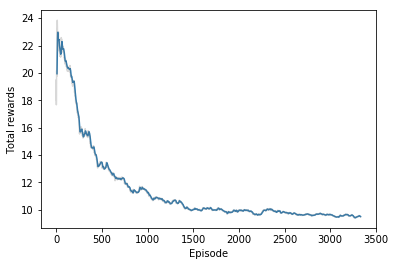

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

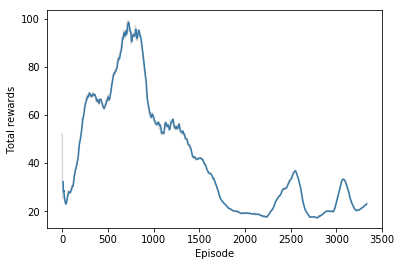

In [83]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

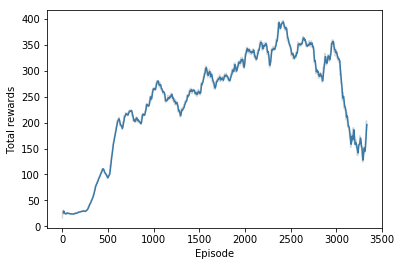

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

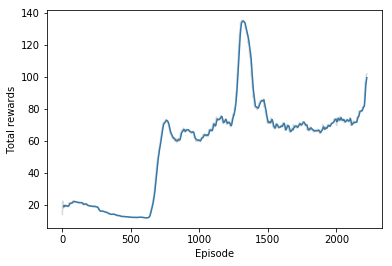

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

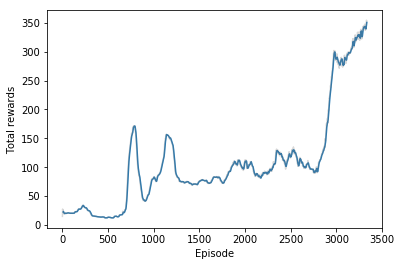

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

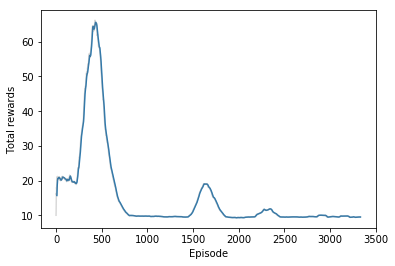

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

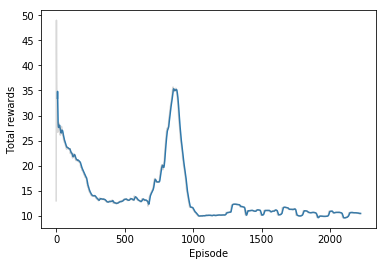

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

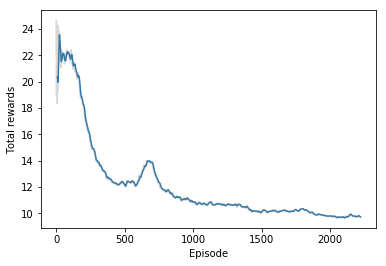

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

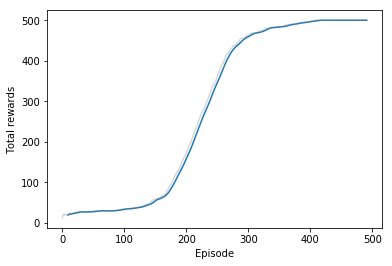

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

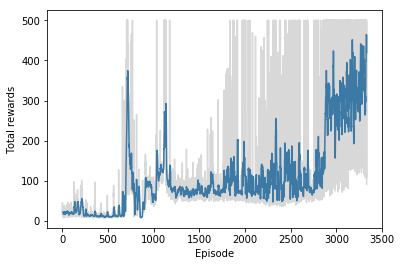

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

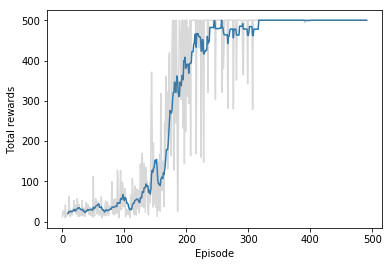

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.